In [ ]:
%%capture
!pip install sentence_transformers faiss-gpu wordcloud
!python -m spacy download en_core_web_sm

In [ ]:
!pip install datasets


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00


# Required Modules

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import faiss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from huggingface_hub import login, HfApi
from sentence_transformers import SentenceTransformer, SentencesDataset, losses
from torch.utils.data import DataLoader
import torch
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler
from sentence_transformers.losses import CosineSimilarityLoss
import logging
from sentence_transformers.readers import STSDataReader
# Load spaCy model
nlp = spacy.load("en_core_web_sm")
tqdm.pandas(desc="Processing texts")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
dataFrame= pd.read_csv("/kaggle/input/medium-articles/medium_articles.csv")

# Reading Our Data

In [ ]:
dataFrame

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."
...,...,...,...,...,...,...
192363,Why do you need a cleaning service?,What could be more important than having a tid...,https://medium.com/@ozneedcleaningau/why-do-yo...,[],2021-11-16 08:17:08.950000+00:00,"['Cleaning', 'Cleaning Services', 'Cleaning Co..."
192364,Daily cleaning and maintenance of bedding,Daily cleaning and maintenance of bedding\n\nW...,https://medium.com/@a198blwt/daily-cleaning-an...,[],2021-11-16 05:27:05.359000+00:00,"['Bedding', 'Cleaning', 'Maintain']"
192365,Beneficial Advice on Bond Cleaning!,The most important chore at the end is bond cl...,https://medium.com/@princegohil/beneficial-adv...,['Prince Shrawan'],2021-11-26 08:20:27.660000+00:00,"['Cleaning', 'End Of Lease Cleaning', 'Cleaners']"
192366,How I Learned Romanian in 37 Easy Steps,How I Learned Romanian in 37 Easy Steps\n\nHey...,https://medium.com/@lifeinromania/how-i-learne...,['Sam Ursu'],2017-11-27 08:09:19.025000+00:00,"['Romania', 'Language Learning', 'Storyofmylife']"


### Select 200 article to fast processing

In [ ]:
dataFrame=dataFrame[:200]

### Split into sentences for setnece transfromer training

In [ ]:
sentences = []
for article in dataFrame['text']:
    sentences.extend(sent_tokenize(article))

In [ ]:
sentences=sentences[:400]

# Cleaning Process

Before extracting search keys, it's important to preprocess and clean the text. Here are the typical cleaning steps:

1. **Tokenize Article**
   - Split the text into individual tokens or words.

2. **Normalize Words**
   - Convert words to lowercase or uppercase to ensure uniformity.

3. **Remove Punctuation**
   - Eliminate punctuation marks to focus on the words.

4. **Remove Stop Words**
   - Exclude common words (e.g., "the", "and") that may not add significant meaning.

5. **Lemmatize the Tokens**
   - Reduce words to their base or root form to consolidate similar words.


In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Lowercase the tokens
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)


### Apply Cleaning

In [ ]:
dataFrame["texts"] = dataFrame["text"].progress_apply(preprocess_text)

Processing texts:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_35/2573001521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame["texts"] = dataFrame["text"].progress_apply(preprocess_text)


### Clean sentences

In [ ]:
sentences=[preprocess_text(sent) for sent in sentences]

In [ ]:
len(sentences)

400

### Create TF-IDF vector to transfer sentence into numbers

In [ ]:
# Create a TF-IDF vectorizer and transform the sentences into vectors
vectorizerTraining = TfidfVectorizer()
sentencesInput= vectorizerTraining.fit_transform(sentences)

### Compute cosine similarity matrix

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(sentencesInput)

### Create pairs

In [ ]:
text1=[]
text2=[]
score=[]
for i in range(len(sentences)):
    for j in range(i, len(sentences)):
        text1.append(sentences[i])
        text2.append(sentences[j])
        score.append(similarity_matrix[i, j])

In [ ]:
df=pd.DataFrame({
'text1': text1,
'text2': text2,
'label': score
})
df

,text1,text2,label
0,photo josh riemer unsplash merry christmas hap...,photo josh riemer unsplash merry christmas hap...,1.000000
1,photo josh riemer unsplash merry christmas hap...,wanted everyone know much appreciate everyone ...,0.171710
2,photo josh riemer unsplash merry christmas hap...,’ anywhere without thank bringing informative ...,0.000000
3,photo josh riemer unsplash merry christmas hap...,without ado ten top story last week curated “ ...,0.000000
4,photo josh riemer unsplash merry christmas hap...,irrespective gender race age religion none u e...,0.000000
...,...,...,...
80195,additionally result another study also suggest...,study researcher found individual decreased ex...,0.351820
80196,additionally result another study also suggest...,especially true individual existing depression,0.000000
80197,study researcher found individual decreased ex...,study researcher found individual decreased ex...,1.000000
80198,study researcher found individual decreased ex...,especially true individual existing depression,0.082699


In [ ]:
traindf, valdf = train_test_split(df, test_size=0.2, random_state=42)
valdf, testdf = train_test_split(valdf, test_size=0.1, random_state=42)

In [ ]:
print("Length train",len(traindf))
print("Length validation",len(valdf))
print("Length testing",len(testdf))

Length train 64160
Length validation 14436
Length testing 1604


### Convert DataFrames to Hugging Face datasets

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(traindf).remove_columns('__index_level_0__')
val_dataset = Dataset.from_pandas(valdf).remove_columns('__index_level_0__')
test_dataset = Dataset.from_pandas(testdf).remove_columns('__index_level_0__')

### Load the pre-trained Sentence Transformer model

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other pre-trained models as well

### Initialize the evaluator

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_dataset["text1"],
    sentences2=val_dataset["text2"],
    scores=val_dataset["label"],
    main_similarity=SimilarityFunction.COSINE
)
dev_evaluator(model)

{'pearson_cosine': 0.6102615518970522,
 'spearman_cosine': 0.3042676205741603,
 'pearson_manhattan': 0.7912178305191585,
 'spearman_manhattan': 0.29661068230708043,
 'pearson_euclidean': 0.7977505947082851,
 'spearman_euclidean': 0.30426741313119726,
 'pearson_dot': 0.6102615487647882,
 'spearman_dot': 0.30426543897512376,
 'pearson_max': 0.7977505947082851,
 'spearman_max': 0.3042676205741603}

### Use cosine similairty loss

In [ ]:
loss = losses.CosineSimilarityLoss(model)

### Specify training arguments

In [ ]:
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/mpnet-base-all",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=800,
    save_strategy="steps",
    save_steps=100,
    logging_steps=100
)


### Create a trainer & train

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)

### Run training

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine,Pearson Manhattan,Spearman Manhattan,Pearson Euclidean,Spearman Euclidean,Pearson Dot,Spearman Dot,Pearson Max,Spearman Max
800,0.004100,0.004052,0.772340,0.291697,0.880912,0.275734,0.891707,0.291697,0.772340,0.291699,0.891707,0.291699
1600,0.003700,0.003741,0.786892,0.302689,0.887709,0.286841,0.899778,0.302689,0.786892,0.302689,0.899778,0.302689
2400,0.003600,0.003562,0.794998,0.306467,0.891635,0.290215,0.903894,0.306467,0.794998,0.306466,0.903894,0.306467
3200,0.003700,0.003410,0.803787,0.317407,0.896580,0.301854,0.909131,0.317408,0.803787,0.317407,0.909131,0.317408
4000,0.003400,0.003342,0.806801,0.323789,0.897954,0.307302,0.910576,0.323789,0.806801,0.323789,0.910576,0.323789


TrainOutput(global_step=4010, training_loss=0.003639269321971106, metrics={'train_runtime': 429.9587, 'train_samples_per_second': 149.224, 'train_steps_per_second': 9.326, 'total_flos': 0.0, 'train_loss': 0.003639269321971106, 'epoch': 1.0})

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=test_dataset["text1"],
    sentences2=test_dataset["text2"],
    scores=test_dataset["label"],
    main_similarity=SimilarityFunction.COSINE
)
dev_evaluator(model)

{'pearson_cosine': 0.7672474426622808,
 'spearman_cosine': 0.33507985856092576,
 'pearson_manhattan': 0.8777169866609156,
 'spearman_manhattan': 0.3298935657067097,
 'pearson_euclidean': 0.8945703096696624,
 'spearman_euclidean': 0.3350798592916911,
 'pearson_dot': 0.7672474665797854,
 'spearman_dot': 0.33507985198403795,
 'pearson_max': 0.8945703096696624,
 'spearman_max': 0.3350798592916911}

### Load all-mpnet-base-v2

This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [ ]:
embedder=model

### Create our Articles Embeeding List

In [ ]:
articles_embeddings = embedder.encode(dataFrame["texts"], convert_to_tensor=True,device='cuda')

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

## Create Faiss Vector DataBase for articles

In [ ]:
dimension = articles_embeddings[0].shape[0]  # Dimension of embeddings
index = faiss.IndexFlatL2(dimension)
index.add(articles_embeddings.cpu().numpy())

### Create Search we use the same preprocessing

In [ ]:
def search(searchKey,k=5):
    searchKey=preprocess_text(searchKey)
    queryVector=embedder.encode(searchKey, convert_to_tensor=True,device='cpu')
    distances, indices=index.search(queryVector.numpy().reshape(1, -1), k)
    return distances, indices

### Let's get The most releveant **5** Articles contains talk about **Social worker**

In [ ]:
query="machine learning"
searchRes=search(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Let's Check the first matched article

In [ ]:
articleIdx=searchRes[1][0][0]
dataFrame.iloc[articleIdx]["texts"]

'machine learning method uncovered hidden clue people ’ language predictive later manifestation psychosis frequent use word associated sound paper published journal npj schizophrenia released finding scientist emory university harvard university hidden detail researcher developed new machine-learning methodology precisely quantify semantic richness people ’ conversational language known indicator psychosis result indicated automated analysis two language variable frequent use word associated sound speaking low semantic density vagueness predict at-risk person later develop psychosis impressive 93 percent accuracy trained clinician noticed individual risk psychosis use word associated sound average population though abnormal auditory perception pre-clinical symptom “ voice living schizophrenia ” webmd youtube machine learning spot pattern people ’ use language even doctor undergone training diagnose treat risk psychosis may notice “ trying hear subtlety conversation people like trying s

### Generate hot keywords

### Approach-1 using **TF-IDF Vectorizer**

#### Create list of 5 matched articles

In [ ]:
matchedArticles=[dataFrame.iloc[idx]["texts"] for idx in searchRes[1][0]]

### Fit TF-IDF vector

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(matchedArticles)
X.shape

(5, 1140)

### Convert TF-IDF matrix to DataFrame

In [ ]:
ttfidf_scores = X.mean(axis=0).A1
words = vectorizer.get_feature_names_out()
# Create a DataFrame for easier handling
tfidf_df = pd.DataFrame({'word': words, 'tfidf': ttfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)
tfidf_df

,word,tfidf
47,ai,0.159174
256,data,0.122734
1102,weather,0.104149
571,learning,0.102854
603,machine,0.099461
...,...,...
16,994,0.003237
21,accelerating,0.003237
31,address,0.003237
1091,waitlist,0.003237


### Get top 30 words

In [ ]:
# Print top keywords
print(tfidf_df.head(30))

              word     tfidf
47              ai  0.159174
256           data  0.122734
1102       weather  0.104149
571       learning  0.102854
603        machine  0.099461
1062         using  0.077359
82      artificial  0.076220
530   intelligence  0.076220
639            min  0.074468
601           lstm  0.074468
684         norris  0.074468
910         series  0.074468
977       stauffer  0.074468
1022          time  0.070330
608           make  0.069066
141       business  0.068558
250       customer  0.064225
778     prediction  0.063718
1013    technology  0.062085
406       forecast  0.060297
809      psychosis  0.058661
167          claim  0.058083
1059           use  0.055799
560       language  0.055678
733         people  0.049939
1111          wind  0.049334
863     researcher  0.044740
915         severe  0.043852
477          human  0.043560
69     application  0.043002


### Generate Word Cloud

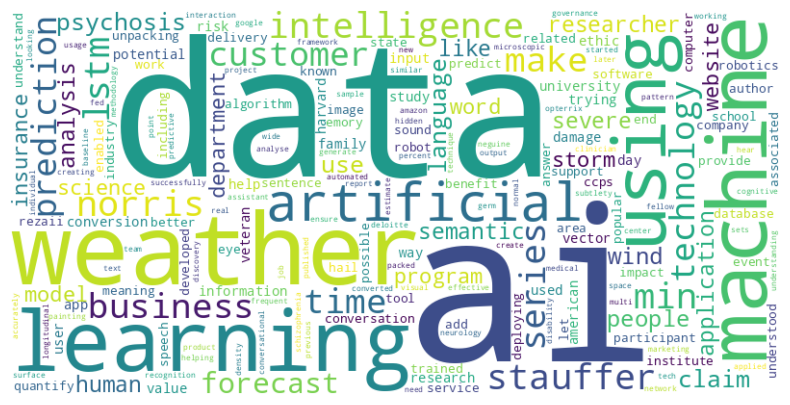

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(tfidf_df['word'], tfidf_df['tfidf'])))
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Count Vectorizer with n-grams

In [ ]:
countvectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
count_matrix = countvectorizer.fit_transform(matchedArticles)

### Convert Count matrix to DataFrame

In [ ]:
count_df = pd.DataFrame(count_matrix.toarray(), columns=countvectorizer.get_feature_names_out())

### show top 10 words

In [ ]:
n=20
sums = count_df.sum(axis=0)
top_n_words = sums.sort_values(ascending=False).head(n)
top_n_words.head()

ai                         55
data                       34
learning                   25
artificial                 25
artificial intelligence    25
dtype: int64

In [ ]:
top_n_words

ai                         55
data                       34
learning                   25
artificial                 25
artificial intelligence    25
intelligence               25
machine                    24
machine learning           22
weather                    19
claim                      16
customer                   16
technology                 14
research                   14
science                    14
use                        13
business                   12
department                 12
researcher                 12
university                 11
forecast                   11
dtype: int64

### Show Word Cloud

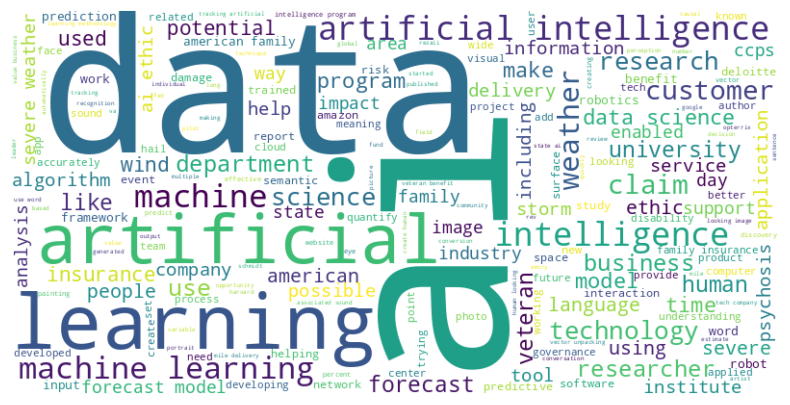

In [ ]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sums.sort_values(ascending=False).to_dict())

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()